In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt 
from sklearn import svm  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
data = pd.read_csv("C:/Users/lenovo/Desktop/乳腺癌诊断数据集/wisc_bc_data.csv")

In [2]:
data.drop("id",axis = 1,inplace=True)
data['diagnosis'] = data['diagnosis'].replace(['M','B'],[1, 0])

In [3]:
columns_to_drop = ["perimeter_mean", "perimeter_se", "perimeter_worst", "area_mean", "area_se", "area_worst", "compactness_mean", "compactness_se", "compactness_worst", "concave points_mean", "concave points_se", "concave points_worst"]
data_new = data.drop(columns_to_drop, axis=1)

In [4]:
data_mean,data_se,data_worst = [],[],[]
for feat in data_new.columns:
    if "mean" in feat:
        data_mean.append(feat)
    elif "se" in feat:
        data_se.append(feat)
    elif "worst" in feat:
        data_worst.append(feat)
print(data_mean)
print(data_se)
print(data_worst)

['radius_mean', 'texture_mean', 'smoothness_mean', 'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean']
['radius_se', 'texture_se', 'smoothness_se', 'concavity_se', 'symmetry_se', 'fractal_dimension_se']
['radius_worst', 'texture_worst', 'smoothness_worst', 'concavity_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [5]:
def standard_scaler(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    scaled_data = (data - mean) / std
    return scaled_data

In [6]:
X = data_new[data_mean]
y = data_new["diagnosis"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)
train_x = standard_scaler(train_x)
test_x = standard_scaler(test_x)

In [7]:
svm_model = svm.SVC(probability=True)
svm_model.fit(train_x, train_y)
predictions = svm_model.predict(test_x)

In [8]:
def confusion_matrix(y_true, y_pred):
    tp = tn = fp = fn = 0
    
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:
            tp += 1
        elif y_true[i] == 0 and y_pred[i] == 0:
            tn += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            fp += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            fn += 1
    
    return [[tn, fp], [fn, tp]]

In [9]:
def custom_classification_report(y_true, y_pred, labels=None, target_names=None):
    """
    生成一个类似于Scikit-Learn的classification_report的分类报告。

    参数:
    y_true (List[int]): 真实标签的列表。
    y_pred (List[int]): 预测标签的列表。
    labels (Optional[List[int]]): 包含在报告中的标签列表。
    target_names (Optional[List[str]]): 与标签对应的可读性更强的名称列表。

    返回:
    str: 表示分类报告的格式化字符串。
    """
    def calculate_metrics(tp, fp, fn):
        precision = tp / (tp + fp) if (tp + fp) else 0
        recall = tp / (tp + fn) if (tp + fn) else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
        return precision, recall, f1_score

    if labels is None:
        labels = sorted(set(y_true))
    if target_names is None:
        target_names = [str(label) for label in labels]
    
    class_metrics = {label: {"tp": 0, "fp": 0, "fn": 0, "support": 0} for label in labels}

    for true, pred in zip(y_true, y_pred):
        if true in labels:
            class_metrics[true]["support"] += 1
            if true == pred:
                class_metrics[true]["tp"] += 1
            else:
                class_metrics[true]["fn"] += 1
                if pred in labels:
                    class_metrics[pred]["fp"] += 1

    report = "              precision    recall  f1-score   support\n\n"
    macro_avg = [0, 0, 0]  # Precision, Recall, F1-Score
    weighted_sum = 0
    for label, name in zip(labels, target_names):
        metrics = class_metrics[label]
        precision, recall, f1_score = calculate_metrics(metrics["tp"], metrics["fp"], metrics["fn"])
        macro_avg[0] += precision
        macro_avg[1] += recall
        macro_avg[2] += f1_score
        weighted_sum += f1_score * metrics["support"]
        report += f"          {name}       {precision:.2f}      {recall:.2f}      {f1_score:.2f}        {metrics['support']}\n"

    total_support = sum(metrics["support"] for metrics in class_metrics.values())
    accuracy = sum(metrics["tp"] for metrics in class_metrics.values()) / total_support
    macro_avg = [x / len(labels) for x in macro_avg]
    weighted_avg = weighted_sum / total_support

    report += f"\n    accuracy                           {accuracy:.2f}       {total_support}\n"
    report += f"   macro avg       {macro_avg[0]:.2f}      {macro_avg[1]:.2f}      {macro_avg[2]:.2f}       {total_support}\n"
    report += f"weighted avg       {weighted_avg:.2f}      {weighted_avg:.2f}      {weighted_avg:.2f}       {total_support}\n"

    return report

In [10]:
confusion_matrix(test_y.values, predictions)

[[66, 1], [6, 41]]

In [11]:
correct = np.count_nonzero((predictions == test_y) == True)
print("Accuracy is: %.4f" % (correct/len(test_x)))

Accuracy is: 0.9386


In [12]:
print(custom_classification_report(test_y, predictions, labels=[0,1], target_names=["良性", "恶性"]))

              precision    recall  f1-score   support

          良性       0.92      0.99      0.95        67
          恶性       0.98      0.87      0.92        47

    accuracy                           0.94       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.94      0.94      0.94       114



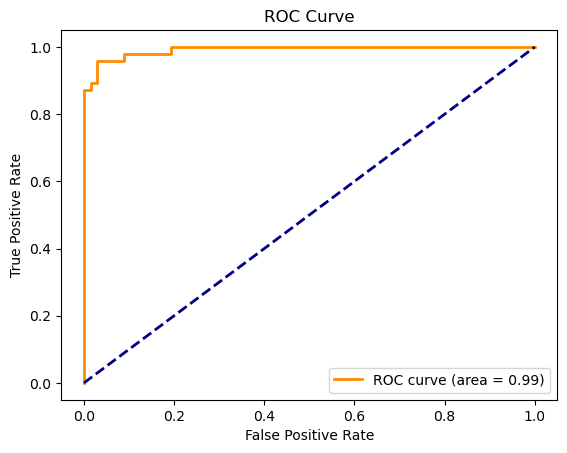

In [13]:
y_score = svm_model.predict_proba(test_x)[:, 1]
fpr, tpr, _ = roc_curve(test_y, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

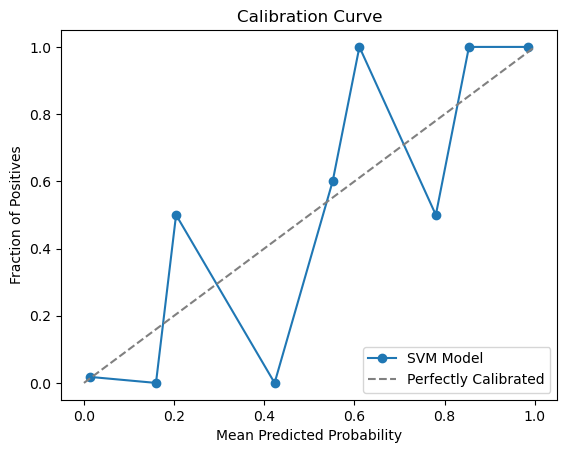

In [14]:
prob_pos = svm_model.predict_proba(test_x)[:, 1]
prob_true, prob_pred = calibration_curve(test_y, prob_pos, n_bins=10, strategy='uniform')
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='SVM Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc='lower right')
plt.show()

In [15]:
labels = data_new['diagnosis']
data = data_new.drop('diagnosis', axis=1)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
data_pca_df = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
data_pca_df['diagnosis'] = labels
data_pca_df = data_pca_df.drop(0)
data_pca_df = data_pca_df.reset_index(drop=True)

手写正确率：92.54%


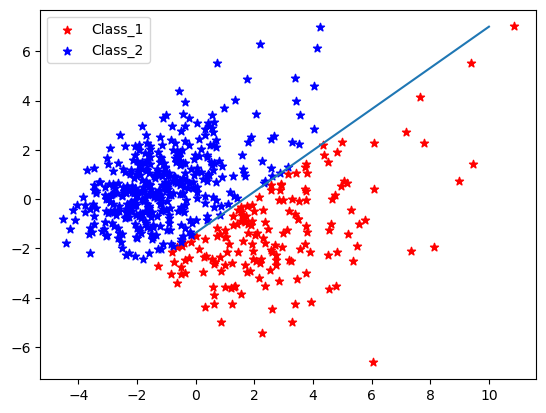

In [16]:
# 定义一个SMO的结构体，用于存储算法中需要的数据    
class SMOStruct:    
    def __init__(self, X, y, C, kernel, toler):    
        # X是样本数据，y是对应的标签，C是正则化参数，kernel是核函数，toler是容忍度    
        self.N = X.shape[0]  # 样本数量    
        self.X = X  # 样本数据    
        self.y = y  # 标签    
        self.C = C  # 正则化参数    
        self.kernel = kernel  # 核函数    
        self.b = 0  # 偏置项    
        self.E = np.zeros(self.N)  # 误差项，初始化为0    
        self.toler = toler  # 容忍度    
        self.lambdas = np.zeros(self.N)  # 拉格朗日乘子，初始化为0    
        self.K = np.zeros((self.N, self.N))  # 核矩阵，初始化为0    
    
        # 计算核矩阵    
        for i in range(self.N):    
            for j in range(self.N):    
                self.K[i, j] = Kernel(X[i].T, X[j].T, kernel)    
    
# 加载数据函数，返回训练集和测试集    
def load_data(path, flag):    
    data = data_pca_df  # 从外部获取数据    
    data = np.array(data).tolist()  # 转换为列表    
    x = []  # 存储特征的列表    
    y = []  # 存储标签的列表    
    for i in range(len(data)):    
        y.append(data[i][-1])  # 获取标签    
        del data[i][-1]  # 删除标签    
        x.append(data[i])  # 获取特征    
    
    # 将标签-1转换为1    
    for i in range(len(y)):    
        if y[i] == 0:    
            y[i] = -1    
    x = np.array(x)  # 转换为numpy数组    
    y = np.array(y).reshape(len(y), )  # 转换为一维numpy数组    
    
    # 划分训练集和测试集    
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.4, random_state=0)    
    
    if flag:  # 如果flag为真，返回全部数据    
        return x, y    
    return x, y, train_x, train_y, test_x, test_y  # 返回划分后的训练集和测试集    
    
# 计算核函数的值    
def Kernel(xi, xj, kernel):    
    res = 0.0  # 初始化结果为0    
    if kernel[0] == 'linear':  # 线性核函数    
        res = np.dot(xi.T, xj)    
    elif kernel[0] == 'rbf':  # 高斯核函数    
        sum = 0.0    
        for i in range(len(xi)):    
            sum += (xi[i] - xj[i]) ** 2    
        res = np.exp(-sum / (2 * kernel[1] ** 2))    
    elif kernel[0] == 'poly':  # 多项式核函数    
        res = np.dot(xi.T, xj)    
        res = res ** kernel[1]    
    elif kernel[0] == 'laplace':  # 拉普拉斯核函数    
        sum = 0.0    
        for i in range(len(xi)):    
            sum += (xi[i] - xj[i]) ** 2    
            sum = sum ** 0.5    
        res = np.exp(-sum / kernel[1])    
    elif kernel[0] == 'sigmoid':  # Sigmoid核函数    
        res = np.dot(xi.T, xj)    
        res = np.tanh(kernel[1] * res + kernel[2])    
    return res  # 返回计算结果    
    
# 判断是否满足KKT条件，用于选择需要优化的变量    
def kkt(model, i):    
    Ei = cacEi(model, i)  # 计算误差项Ei    
    if ((model.y[i] * Ei < -model.toler) and (model.lambdas[i] < model.C)) or ( # 判断条件1和条件2是否满足KKT条件    
            (model.y[i] * Ei > model.toler) and (model.lambdas[i] > 0)): # 判断条件3和条件4是否满足KKT条件    
        return True  # 如果满足KKT条件，返回True，表示需要优化该变量    
    else:    
        return False  # 如果不满足KKT条件，返回False，表示不需要优化该变量  
# 选择lambda_i，这是SMO算法中的外循环，用于选择第一个待优化的拉格朗日乘子    
def outerLoop(model):    
    for i in range(model.N):  # 遍历所有的拉格朗日乘子    
        if kkt(model, i):  # 如果当前乘子不满足KKT条件    
            return i  # 则选择这个乘子进行优化    
    
# 选择lambda_j，这是SMO算法中的内循环，用于选择第二个待优化的拉格朗日乘子    
def inner_loop(model, i):    
    E1 = cacEi(model, i)  # 计算E_i    
    max_diff = 0    
    j = None    
    E = np.nonzero(model.E)[0]  # 找到所有非零的E    
    if len(E) > 1:  # 如果存在多个非零的E    
        for k in E:    
            if k == i:  # 排除已选择的i    
                continue    
            Ek = cacEi(model, k)  # 计算E_k    
            diff = np.abs(Ek - E1)  # 计算|E_k - E_i|    
            if diff > max_diff:  # 选择使|E_k - E_i|最大的k作为j    
                max_diff = diff    
                j = k    
    else:  # 如果不存在多个非零的E，则随机选择一个j    
        j = i    
        while j == i:    
            j = int(np.random.uniform(0, model.N))    
    return j    
    
# 计算f(xk)，这是SVM的预测函数，用于计算样本x_k的预测值    
def calfx(model, k):    
    sum = 0.0    
    for i in range(model.N):  # 遍历所有的支持向量    
        sum += (model.lambdas[i] * model.y[i] * model.K[i, k])  # 计算点积并累加    
    sum += model.b  # 加上偏置b    
    return sum    
    
# 计算E_k，这是计算样本x_k的预测误差，用于后续的优化过程    
def cacEi(model, k):    
    return calfx(model, k) - float(model.y[k])  # 预测值减去真实值得到误差    
    
# 核心程序，更新lambda和b，这是SMO算法的主要部分，用于优化选定的两个拉格朗日乘子，并更新偏置b    
def update(model, i, j):    
    lambdai_old = model.lambdas[i]  # 保存旧的拉格朗日乘子值    
    lambdaj_old = model.lambdas[j]    
    if model.y[i] != model.y[j]:  # 根据y_i和y_j的关系计算L和H的值    
        L = max(0.0, model.lambdas[j] - model.lambdas[i])    
        H = min(model.C, model.C + model.lambdas[j] - model.lambdas[i])    
    else:    
        L = max(0.0, model.lambdas[j] + model.lambdas[i] - model.C)    
        H = min(model.C, model.lambdas[j] + model.lambdas[i])    
    if L == H:  # 如果L等于H，则无需更新，直接返回0表示没有更新发生    
        return 0    
    eta = model.K[i, i] + model.K[j, j] - 2.0 * model.K[i, j]  # 计算eta值，用于后续计算新的lambda_j    
    if eta <= 0:  # 如果eta小于等于0，则无需更新，直接返回0表示没有更新发生    
        return 0    
    lambdaj_new_unc = lambdaj_old + \
        model.y[j] * (model.E[i] - model.E[j]) / eta    # 计算未经剪辑的新的lambda_j值
    lambdaj_new = clipBonder(L, H, lambdaj_new_unc)  # 对新的lambda_j值进行剪辑，确保其在[L, H]范围内    
    lambdai_new = lambdai_old + model.y[i] * \
        model.y[j] * (lambdaj_old - lambdaj_new) # 根据lambda_j的更新量计算新的lambda_i值 
    # 更新 lambda和b值    
    model.lambdas[i] = lambdai_new    
    model.lambdas[j] = lambdaj_new    
    b1 = model.b - model.E[i] - model.y[i] * (lambdai_new - lambdai_old) * model.K[i, i] - model.y[j] * (lambdaj_new - lambdaj_old) * model.K[i, j]  # 计算b1的值    
    b2 = model.b - model.E[j] - model.y[i] * (lambdai_new - lambdai_old) * model.K[i, j] - model.y[j] * (lambdaj_new - lambdaj_old) * model.K[j, j]  # 计算b2的值    
    if 0 < model.lambdas[i] < model.C:  # 根据KKT条件更新b的值    
        model.b = b1    
    elif 0 < model.lambdas[j] < model.C:    
        model.b = b2    
    else:    
        model.b = (b1 + b2) / 2.0  # 如果两个乘子都不在边界上，则取b1和b2的平均值作为新的b值    
    # 更新 E值，用于下一轮的优化过程    
    model.E[i] = cacEi(model, i)    
    model.E[j] = cacEi(model, j)    
    return 1  # 返回1表示发生了更新  
# 计算权重向量w    
def calW(lambdas, X, y):    
    m, n = X.shape  # 获取输入数据X的行数和列数    
    w = np.zeros((n, 1))  # 初始化权重向量w为n行1列的零向量    
    for i in range(n):  # 遍历权重向量的每个元素    
        for j in range(m):  # 遍历输入数据的每个样本    
            w[i] += (lambdas[j] * y[j] * X[j, i])  # 更新权重向量w的元素值    
    return w  # 返回计算得到的权重向量w    
    
    
# 确保lambda值在指定范围内    
def clipBonder(L, H, lambda_):    
    if lambda_ > H:  # 如果lambda值大于上限H    
        return H  # 返回上限H    
    elif H >= lambda_ >= L:  # 如果lambda值在上下限之间    
        return lambda_  # 返回lambda值本身    
    else:  # 如果lambda值小于下限L    
        return L  # 返回下限L    
    
    
# 使用SMO算法训练SVM的主程序    
def smo_main(C, kernel, toler):    
    x, y, train_x, train_y, test_x, test_y = load_data(    
        'svm_data/svmdata.txt', False)  # 加载数据    
    model = SMOStruct(train_x, train_y, C, kernel, toler)  # 初始化SMOStruct对象    
    max_step = 50  # 设置最大迭代步数为50    
    while max_step > 0:  # 在最大步数内循环运行SMO算法    
        for i in range(model.N):  # 遍历所有样本    
            if kkt(model, i):  # 检查是否满足KKT条件    
                j = inner_loop(model, i)  # 选择第二个样本进行优化    
                update(model, i, j)  # 更新模型参数    
        max_step -= 1  # 更新迭代步数    
    w = calW(model.lambdas, model.X, model.y)  # 计算权重向量w    
    return model, model.lambdas, w, model.b  # 返回模型及相关参数    
    
    
# 绘制SVM分类结果图    
def plotSVM(model, w):    
    x, y, train_x, train_y, test_x, test_y = load_data(    
        'svm_data/svmdata.txt', False)  # 加载数据    
    w1 = w[0, 0]  # 获取权重向量的第一个元素    
    w2 = w[1, 0]  # 获取权重向量的第二个元素    
    b = model.b  # 获取偏置项b    
    x0 = []  # 存储正类样本的x坐标    
    x1 = []  # 存储负类样本的x坐标    
    y0 = []  # 存储正类样本的y坐标    
    y1 = []  # 存储负类样本的y坐标    
    for i in range(len(x)):  # 遍历所有样本    
        res = np.dot(w.T, x[i, :]) + b  # 计算样本的分类结果    
        res = np.sign(res)  # 取分类结果的符号（+1或-1）    
        if res == 1:  # 如果分类结果为正类（+1）    
            x0.append(x[i, 0])  # 将样本的x坐标添加到正类列表x0中    
            y0.append(x[i, 1])  # 将样本的y坐标添加到正类列表y0中    
        else:  # 如果分类结果为负类（-1）    
            x1.append(x[i, 0])  # 将样本的x坐标添加到负类列表x1中    
            y1.append(x[i, 1])  # 将样本的y坐标添加到负类列表y1中    
    plt.scatter(x0, y0, c='red', marker='*')  # 绘制正类样本点（红色星号）    
    plt.scatter(x1, y1, c='blue', marker='*')  # 绘制负类样本点（蓝色星号）    
    plt.legend(['Class_1', 'Class_2'])  # 添加图例，分别表示正类和负类    
    x2 = np.linspace(0, 10, 1000)  # 生成一个从0到10的等差数列，用于绘制分类超平面    
    y2 = -b / w2 - w1 / w2 * x2  # 计算分类超平面的y坐标    
    plt.plot(x2, y2)  # 绘制分类超平面（直线）    
    plt.show()  # 显示图形界面，展示分类结果图  
def SVM():    
    # 声明 pred_y 为全局变量，以便在其他函数中也能访问到这个变量    
    global pred_y    
        
    # 设置 SVM 算法的参数    
    C = 1.0  # 惩罚系数    
    toler = 0.001  # 容差值，用于控制算法的收敛程度    
    kernel = ['linear', 0.5, 0.0]  # 核函数类型及其参数    
        
    # 调用 smo_main 函数训练 SVM 模型，并获取模型、拉格朗日乘子、权重向量和偏置项    
    model, lambdas, w, b = smo_main(C, kernel, toler)    
        
    # 加载数据，包括特征矩阵 x、标签向量 y、训练集特征矩阵 train_x、训练集标签向量 train_y、测试集特征矩阵 test_x、测试集标签向量 test_y    
    x, y, train_x, train_y, test_x, test_y = load_data('svm_data/svmdata.txt', False)    
        
    # 初始化正确分类的样本数为 0    
    sum = 0    
        
    # 遍历测试集的每个样本，进行预测并与真实标签比较，计算分类正确的样本数    
    for i in range(len(test_y)):    
        res = np.dot(w.T, test_x[i, :]) + b  # 计算样本的预测结果    
        res = np.sign(res)  # 将预测结果转换为 +1 或 -1 的形式    
        if res == test_y[i]:  # 如果预测结果与真实标签相同，则分类正确    
            sum += 1  # 正确分类的样本数加 1    
        
    # 计算分类准确率，并打印出来    
    print('手写正确率：%.2f%%' % (sum / len(test_y) * 100))    
        
    # 调用 plotSVM 函数绘制 SVM 分类结果图    
    plotSVM(model, w)    
    
# 调用 SVM 函数，开始执行程序    
SVM()  